---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

#Load Libraries

In [1]:
# Libraries
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from matplotlib import cm
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.feature_selection import SelectKBest
from sklearn.externals import joblib
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

# Preprocess the Data

In [2]:
# Obtain the data
train = pd.read_csv('train.csv', encoding = "Latin-1", low_memory = False)
addresses = pd.read_csv('addresses.csv')
latlong = pd.read_csv('latlons.csv')

# Merge in lat long data
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder

train = pd.merge(train, addresses, on = ['ticket_id'])
train = pd.merge(train, latlong, on = ['address'])

# Remove observations where offender ruled not responsible
train = train.fillna(0)

# Add the number of days between hearing data and ticket date
train['payment_days'] = (pd.to_datetime(train['hearing_date']) - pd.to_datetime(train['ticket_issued_date'])).dt.days

# Select variables of interest
features = ['agency_name', 'inspector_name',  'violation_code',
            'judgment_amount','payment_days', 'lat', 'lon', 'compliance']
train = train[features]
train = train.dropna()

# Convert categorical variables to numeric
le = preprocessing.LabelEncoder()
categorical = list(train.select_dtypes(include=['object']).columns.values)
for cat in categorical:
    train[cat] = le.fit_transform(train[cat].astype(str))


X = train.drop("compliance", axis=1)
y = train['compliance']

# Split the training data further into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Model Survey
## Logistic Regression, Decision Trees, Naive Bayes, Random Forests, and Gradient Boost

In [6]:
print(50*"=")
print("Section 1: Survey of Candidate Models
print(50*'-')

# Construct some pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', LogisticRegression(random_state=5))])

pipe_nb = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', GaussianNB())])

pipe_svm1 = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', SVC(random_state=5, C=.00001, probability=True))])
            
pipe_dt = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', tree.DecisionTreeClassifier(random_state=5))])

pipe_rf = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', RandomForestClassifier(random_state=5))])

pipe_gb = Pipeline([('scl', StandardScaler()),
            ('pca', PCA(n_components=2)),
            ('clf', GradientBoostingClassifier(random_state=5))])


# List of pipelines for ease of iteration
pipelines = [pipe_lr, pipe_nb, pipe_svm1, pipe_svm2, pipe_svm3, pipe_dt, pipe_rf, pipe_gb]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression',  1: 'Naive Bayes', 2: 'Support Vector Machine (1)',
             3: 'Support Vector Machine (2)', 4: 'Support Vector Machine (3)',
             5: 'Decision Tree', 6: 'Random Forests', 7: 'Gradient Boosting'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, y_train)
    
# Compare AUC scoes
for idx, val in enumerate(pipelines):
    print ('%s pipeline AUC score: %.3f' % (pipe_dict[idx], roc_auc_score(y_test, val.predict_proba(X_test)[:,1])))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''
for idx, val in enumerate(pipelines):
    score = roc_auc_score(y_test, val.predict_proba(X_test)[:,1])
    if score > best_acc:
        best_acc = score
        best_pipe = val
        best_clf = idx
print('Classifier with AUC: %s' % pipe_dict[best_clf])

# Save pipeline to file
joblib.dump(best_pipe, 'best_pipeline.pkl', compress=1)
print('Saved %s pipeline to file' % pipe_dict[best_clf])

Section 1: Create transformers and Default, Logistic Regression, Naive Bayes, Decision Tree and Random Forest Estimators
--------------------------------------------------
Logistic Regression pipeline AUC score: 0.532
Naive Bayes pipeline AUC score: 0.533
Support Vector Machine pipeline AUC score: 0.502
Decision Tree pipeline AUC score: 0.573
Random Forests pipeline AUC score: 0.626
Gradient Boosting pipeline AUC score: 0.583
Classifier with AUC: Random Forests
Saved Random Forests pipeline to file


# Random Forests
## Parameter Tuning

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean AUC score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
print(50*"=")
print("Section 2: Evaluating Random Forests")
print(50*'-')

# Build classifier
clf = RandomForestClassifier()

# Set parameter grid
param_grid = {"n_estimators": range(20,101,10) 
              "max_depth": range(2,21,2),
              "max_features": ['auto', 'sqrt'],
              "min_samples_split": [2, 10, 100, 1000],
              "min_samples_leaf": [2,10,20,40],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
model_rf = GridSearchCV(clf, param_grid=param_grid, n_jobs=4, scoring="roc_auc")
start = time()
model_rf.fit(X_train, y_train)
report(model_rf.cv_results_)
print ('%s pipeline AUC score: %.3f' % ("Random Forests", 
                                        roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1])))

Section 2: Evaluating Random Forests
--------------------------------------------------


# Gradient Boosted Decision Trees (GBM) Parameter Tuning

In [12]:
def modelfit(alg, X_train, y_train, X_test, y_test, features, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(y_test, dtest_predprob))
    
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, features).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Fix learning rate and number of estimators for tuning tree-based parameters

In [9]:
print(50*"=")
print("Section 3: Parameter Tuning for Gradient-Boosted Decision Trees")
print(50*'-')
print("        3.1: Learning Rate & Estimators")
print(50*'-')

param_test1 = {'n_estimators':range(20,101,10)}
gbm_gs1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.375, 
                                                             min_samples_split=500,
                                                             min_samples_leaf=50,
                                                             max_depth=8,
                                                             max_features='sqrt',
                                                             subsample=0.8,
                                                             random_state=5), 
                      param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gbm_gs1.fit(X_train, y_train)
gbm_gs1.best_params_, gbm_gs1.best_score_

Section 3: Parameter Tuning for Gradient-Boosted Decision Trees
--------------------------------------------------
        3.1: Learning Rate & Estimators
--------------------------------------------------


({'n_estimators': 60}, 0.86173469966252969)

## Tree Based Parameters 
### Max Depth and Minimum Samples per Split

In [10]:
print(50*"-")
print("Section 3.2: Parameter Tuning for Gradient-Boosted Decision Trees: Max Depth & Min Samples per Split")
print(50*'-')

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(800,2001,200)}
gbm_gs2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.375, 
                                                              n_estimators=60, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=5), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gbm_gs2.fit(X_train, y_train)
gbm_gs2.best_params_, gbm_gs2.best_score_

--------------------------------------------------
Section 3.2: Parameter Tuning for Gradient-Boosted Decision Trees: Max Depth & Min Samples per Split
--------------------------------------------------


({'max_depth': 9, 'min_samples_split': 1600}, 0.86262238058726715)

### Minimum Samples per Split and Minimum Samples per Leaf

In [11]:
print(50*"-")
print("Section 3.3: Parameter Tuning for Gradient-Boosted Decision Trees: Min. Samples per Split and Leaf")
print(50*'-')

param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gbm_gs3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.375, 
                                                              n_estimators=60, 
                                                              max_features='sqrt', 
                                                              max_depth=9,
                                                              subsample=0.8, 
                                                              random_state=5), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gbm_gs3.fit(X_train, y_train)
gbm_gs3.best_params_, gbm_gs3.best_score_

--------------------------------------------------
Section 3.3: Parameter Tuning for Gradient-Boosted Decision Trees: Min. Samples per Split and Leaf
--------------------------------------------------


({'min_samples_leaf': 40, 'min_samples_split': 1200}, 0.86295677577512353)

--------------------------------------------------
Section 3.4: Parameter Tuning for Gradient-Boosted Decision Trees: Max Features
--------------------------------------------------

Model Report
Accuracy : 0.9611
AUC Score (Train): 0.909066
AUC Score (Test): 0.854710
CV Score : Mean - 0.8629568 | Std - 0.003258533 | Min - 0.8569313 | Max - 0.865859


<IPython.core.display.Javascript object>


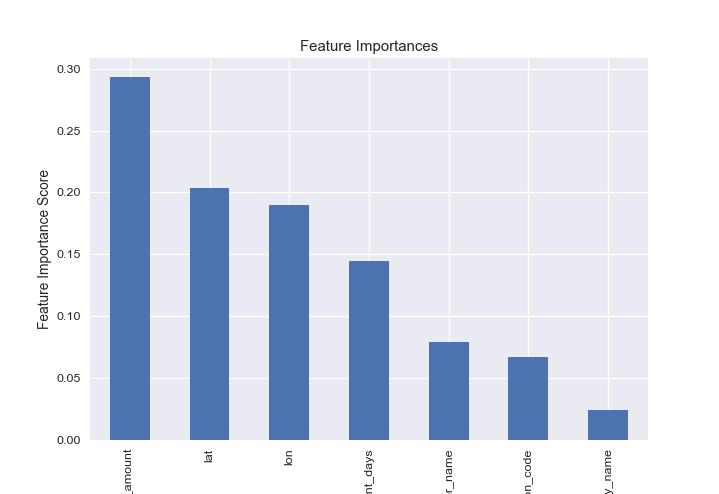

In [14]:
print(50*"-")
print("Section 3.4: Parameter Tuning for Gradient-Boosted Decision Trees: Max Features")
print(50*'-')

features = X_train.shape[1]
param_test4 = {'max_features':range(2,features,2)}
gbm_gs4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.375, 
                                                              n_estimators=60, 
                                                              max_features='sqrt', 
                                                              max_depth=9,
                                                              min_samples_leaf=40,
                                                              min_samples_split=1200,
                                                              subsample=0.8, 
                                                              random_state=5), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gbm_gs4.fit(X_train, y_train)
gbm_gs4.best_params_, gbm_gs4.best_score_
modelfit(gbm_gs4.best_estimator_, X_train, y_train, X_test, y_test, features = list(X_train.columns.values))

### Tune Learning Rate vis-a-vis Number of Estimators

In [21]:
print(50*"-")
print("Section 3.5: Parameter Tuning for Gradient-Boosted Decision Trees: Learning Rate and Num Estimators")
print(50*'-')
def gbmEvaluator(X_train, y_train, X_test, y_test, learning_rate, n_estimators):
    gbm_tuned = GradientBoostingClassifier(learning_rate=learning_rate, 
                                           n_estimators=n_estimators, 
                                           max_features=2, 
                                           max_depth=15,
                                           min_samples_leaf=60,
                                           min_samples_split=1600,
                                           subsample=0.8, 
                                           random_state=5)
    gbm_tuned.fit(X_train, y_train)
    modelfit(gbm_tuned, X_train, y_train, X_test, y_test, features = list(X_train.columns.values))

learning_rates = [.3, .3/2, .3/10, .3/20]
n_estimators = [70, 70*2, 70*10, 70*20]
for lr, est in zip(learning_rates, n_estimators):
    gbmEvaluator(X_train, y_train, X_test, y_test, lr, est)
    

--------------------------------------------------
Section 3.5: Parameter Tuning for Gradient-Boosted Decision Trees: Learning Rate and Num Estimators
--------------------------------------------------

Model Report
Accuracy : 0.9433
AUC Score (Train): 0.889348
AUC Score (Test): 0.812646
CV Score : Mean - 0.8037119 | Std - 0.006508282 | Min - 0.7982864 | Max - 0.8162522

Model Report
Accuracy : 0.9438
AUC Score (Train): 0.896345
AUC Score (Test): 0.821762
CV Score : Mean - 0.8082644 | Std - 0.006641414 | Min - 0.8022975 | Max - 0.8203171

Model Report
Accuracy : 0.9443
AUC Score (Train): 0.904220
AUC Score (Test): 0.827907
CV Score : Mean - 0.8132952 | Std - 0.006349687 | Min - 0.8078655 | Max - 0.8252467

Model Report
Accuracy : 0.9443
AUC Score (Train): 0.902832
AUC Score (Test): 0.827952
CV Score : Mean - 0.8144183 | Std - 0.006741235 | Min - 0.8077991 | Max - 0.8269517


# Neural Networks

In [25]:
print(50*"=")
print("Section 4: Parameter Tuning for Neural Network")
print(50*'-')

# Set parameter grid
param_grid = {"hidden_layer_sizes": [10, 10],
              "activation": ['logistic', 'tanh', 'relu'],
              "solver": ['lbfgs', 'sgd', 'adam'],
              "alpha": [0.01, 0.1, 1.0, 5.0],
              'max_iter': [500,1000,1500]}

nn_gs = GridSearchCV(estimator = MLPClassifier(random_state=5), 
                       param_grid = param_grid, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
nn_gs.fit(X_train, y_train)
nn_gs.best_params_, nn_gs.best_score_
modelfit(nn_gs.best_estimator_, X_train, y_train, X_test, y_test, features = list(X_train.columns.values))

Section 4: Parameter Tuning for Neural Network
--------------------------------------------------

Model Report
Accuracy : 0.9283
AUC Score (Train): 0.539167
AUC Score (Test): 0.534671
CV Score : Mean - 0.5720955 | Std - 0.04459888 | Min - 0.5130357 | Max - 0.6503562
